# Regression models pipeline

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

setup_notebook()

In [2]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [3]:
DATA_PATH = '../../data/'
FILE_SUFFIX = '.txt'
price_column = 'Close'
quotation='AAPL'

In [4]:
OUTPUT_PATH = 'results/'
METRICS_PATH = f"{OUTPUT_PATH}metrics/regression/"
PIPELINE_LABEL = 'ml_reg'

In [5]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}", compute_features=True, predict_n=1, thresh_diff=None, normalize=True)
data_columns = ['Close', 'PercentageDiff', f"RSI(14)", 'Volume', 'LowLen']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='NextPrice', 
                                                             features_list=data_columns)

## Classifier and evaluation

### Grid Search

In [6]:
from sklearn.model_selection import TimeSeriesSplit
# build the time series split for cross validation so no data leakage
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

N_JOBS=4

# default parameters
best_params = {'DTree': {'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}, 'SVM': {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}, 'LR': {'fit_intercept': False}}
param_grid = {
    'DTree':{
        'criterion':('mae', 'mse'),
        'max_depth':[3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('mae', 'mse'),
        'n_estimators':[100,200, 500],
        'max_depth':[3,5,8,],
        'min_samples_leaf':[3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        #'C':[1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 100.0],
        'C':[0.1, 1.0, 10.0, 50.0, 100.0, 200.0],
        'epsilon':[0.1, 1.0, 10.0, 100.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':['scale'],
    },
    'LR':
    {
        'normalize':[True, False],
        'fit_intercept':[True, False],
    },   
    
}

def compute_grid_search(param_grid, X_train, y_train, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_params = {}
    
    print("Performing grid search...")
    dtree = DecisionTreeRegressor(random_state=42)
    clf = GridSearchCV(dtree, param_grid['DTree'], cv=tscv.split(X_train), n_jobs=N_JOBS, verbose=2)
    clf.fit(X_train, y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], cv=tscv.split(X_train), n_jobs=N_JOBS, verbose=32)
    clf.fit(X_train, y_train)
    best_params['RandomForest'] = clf.best_params_
    
    svm = SVR(cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], cv=tscv.split(X_train), n_jobs=N_JOBS, verbose=32)
    clf.fit(X_train, y_train)
    best_params['SVM'] = clf.best_params_
    
    lr = LinearRegression()
    clf = GridSearchCV(lr, param_grid['LR'], cv=tscv.split(X_train), n_jobs=N_JOBS, verbose=2)
    clf.fit(X_train, y_train)
    best_params['LR'] = clf.best_params_
    return best_params


#best_params = compute_grid_search(param_grid, X_train, y_train)

### Classifiers

In [17]:
reg_dict = {}

"""reg_dict['DTree'] = DecisionTreeRegressor(**best_params['DTree'], random_state=42)
reg_dict['RandomForest'] = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
reg_dict['SVM'] = SVR(**best_params['SVM'], random_state=42)
reg_dict['LR'] = LinearRegression(**best_params['LR'], random_state=42)"""

"reg_dict['DTree'] = DecisionTreeRegressor(**best_params['DTree'], random_state=42)\nreg_dict['RandomForest'] = RandomForestRegressor(**best_params['RandomForest'], random_state=42)\nreg_dict['SVM'] = SVR(**best_params['SVM'], random_state=42)\nreg_dict['LR'] = LinearRegression(**best_params['LR'], random_state=42)"

### Training

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def train_evaluate_regressors(reg_dict, X_train, y_train, X_test, y_test):
    reg_metrics = {}
    for reg_label, reg in reg_dict.items():
        reg.fit(X_train, y_train)
        #y_pred = clf.predict(X_train)
        #print(f"Training accuracy : {accuracy_score(y_pred, y_train)}")
        y_pred = reg.predict(X_test)

        mse = mean_squared_error(y_pred, y_test)
        mae = mean_absolute_error(y_pred, y_test)
        mape = mean_absolute_percentage_error(y_pred, y_test)

        #print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
        #plot_confusion_matrix(clf, X_test, y_test, normalize='true')
        reg_metrics[reg_label] = {'mse':mse, 'mae':mae, 'mape':mape}
        
    return reg_metrics

### Pipeline

In [19]:
USE_CLASS_WEIGHTS = True
PERFORM_GRID_SEARCH = True
MAX_SIZE = 2000
n_splits=5

quotations = ['AAL', 'AAPL', 'AMZN','CMCSA', 'COST', 'GM', 'GOOG', 'IBM', 'JNJ', 'KO','PEP', 'TSLA', 'WMT', 'XOM']
days_predict_feature_set = {
    1:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band', 'GAP', 'MACD_diff'],
    5:['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD'],
    10:['Volume', 'Close', 'BodyLen', 'Difference', 'SMA(20) - SMA(10)', 'EMA_Diff', 'MACD_diff'],
    20:['Volume', 'Close', 'LowLen', 'Difference', 'EMA(14)', 'BG_H_Band', 'MACD_diff'],
    50:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band','GAP','MACD_diff'],
}

#quotations=['CMCSA']
#days_predict_feature_set = {1:days_predict_feature_set[1]}

In [20]:
predict_n_metrics_dict = {}

In [26]:
for predict_n, features_list in tqdm(days_predict_feature_set.items()):
    if predict_n in [1,5,10]:
        continue
    quot_metrics_dict = {}
    for quot in tqdm(quotations):
        data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", compute_features=True, 
                                                   predict_n=predict_n, thresh_diff=None, normalize=True)


        X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                                     y_column='NextPrice', 
                                                                     features_list=features_list)
        



        if PERFORM_GRID_SEARCH:
            # ceil the number of samples, get the lasts MAX_SIZE samples 
            best_params = compute_grid_search(param_grid, 
                                              X_train=X_train[-MAX_SIZE:],
                                              y_train=y_train[-MAX_SIZE:],
                                              n_splits=n_splits)
            
            params_df = pd.DataFrame.from_dict(best_params)
            params_df.to_csv(f"results/grid_search/regression/{predict_n}_{quot}.csv", index=False)

        reg_dict = {}

        reg_dict['DTree'] = DecisionTreeRegressor(**best_params['DTree'], random_state=42)
        reg_dict['RandomForest'] = RandomForestRegressor(**best_params['RandomForest'], random_state=42)
        reg_dict['SVM'] = SVR(**best_params['SVM'])
        reg_dict['LR'] = LinearRegression(**best_params['LR'])

        
        quot_metrics_dict[quot] = train_evaluate_regressors(reg_dict, X_train, y_train, X_test, y_test)
        
    """metrics_df = pd.DataFrame.from_dict(quot_metrics_dict).T
    acc_df = metrics_df.applymap(lambda metrics: metrics['acc'])
    f1_df = metrics_df.applymap(lambda metrics: metrics['f1'])

    acc_df.to_csv(f"metrics/acc_{predict_n}.csv", index=True)
    f1_df.to_csv(f"metrics/f1_{predict_n}.csv", index=True)
    """
    predict_n_metrics_dict[predict_n] = quot_metrics_dict.copy()
    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each o

  0%|          | 0/14 [00:00<?, ?it/s]

Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Performing grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each o

In [27]:
predict_n_metrics_dict

{1: {'AAL': {'DTree': {'mse': 0.00040002611775352936,
    'mae': 0.01517712473316475,
    'mape': 0.03865700863537383},
   'RandomForest': {'mse': 0.00026469454356206737,
    'mae': 0.011830471121597129,
    'mape': 0.0317035815048061},
   'SVM': {'mse': 0.0012326616718660055,
    'mae': 0.027130217484537124,
    'mape': 0.08522520213496947},
   'LR': {'mse': 0.0002459189601130199,
    'mae': 0.011412489432978266,
    'mape': 0.03143306038231758}},
  'AAPL': {'DTree': {'mse': 0.0639864274135731,
    'mae': 0.1675341345697533,
    'mape': 0.5330979677282099},
   'RandomForest': {'mse': 0.06479528918158887,
    'mae': 0.1696178740919568,
    'mape': 0.5438718114409096},
   'SVM': {'mse': 0.13882785240228357,
    'mae': 0.31834349124692446,
    'mape': 1.9994437529407039},
   'LR': {'mse': 0.0001616190201255988,
    'mae': 0.007981748225476632,
    'mape': 0.016132374904576908}},
  'AMZN': {'DTree': {'mse': 0.04761110137745437,
    'mae': 0.14974067628169763,
    'mape': 0.340082834276155

In [28]:
print(METRICS_PATH)

results/metrics/regression/


In [30]:
save_dict(dict_save=predict_n_metrics_dict, path=f"{METRICS_PATH}{PIPELINE_LABEL}_dict.txt")

In [ ]:
#print(quot_metrics_dict)

for quot, classifiers in quot_metrics_dict.items():
    print(f"[{quot}]")
    for label, metrics in classifiers.items():
        print(f"\t[{label}] : acc :  {metrics['acc']:.2f}, f1 : {metrics['f1']:.2f}")
    
    print("\n")


In [35]:
metrics_list = ['mae', 'mse', 'mape']

In [2]:
print(f"{METRICS_PATH}")

NameError: name 'METRICS_PATH' is not defined

In [44]:
for predict_n, quot_metrics in predict_n_metrics_dict.items():
    metrics_df = pd.DataFrame.from_dict(quot_metrics).T
    
    for metric in metrics_list:
        filtered_df = metrics_df.applymap(lambda metrics: metrics[metric])
        filtered_df = filtered_df.round(4)
        plt.figure()
        heatmap = sns.heatmap(filtered_df, cmap ='mako_r', linewidths = 0.5, annot = True)
        heatmap.figure.savefig(f"{METRICS_PATH}{predict_n}_{metric}.png")
        plt.close()
    """#print(metrics_df)
    acc_df = metrics_df.applymap(lambda metrics: metrics['acc'])
    f1_df = metrics_df.applymap(lambda metrics: metrics['f1'])
    
    plt.figure()
    acc_heatmap = sns.heatmap(acc_df, cmap ='mako', linewidths = 0.5, annot = True)
    acc_heatmap.figure.savefig(f"{METRICS_PATH}{predict_n}_acc.png")
    plt.close()
    
    plt.figure()
    f1_heatmap = sns.heatmap(f1_df, cmap ='mako', linewidths = 0.5, annot = True)
    f1_heatmap.figure.savefig(f"{METRICS_PATH}{predict_n}_f1.png")
    plt.close()"""

<AxesSubplot:title={'center':'Prices predictions and true values'}, ylabel='Price (USD)'>

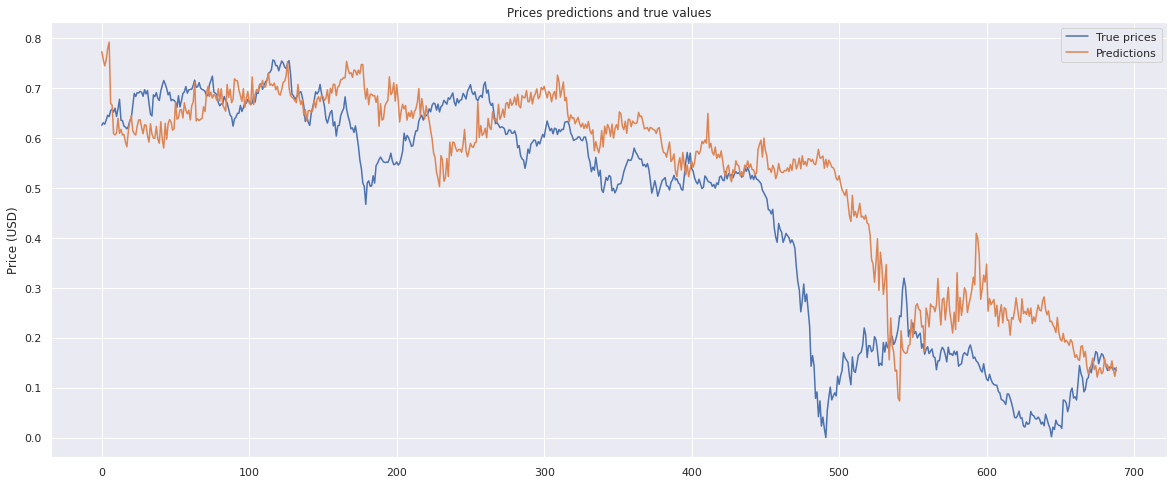

In [55]:
from helpers.plots_helper import *
y_pred = reg_dict['LR'].predict(X_test)

plot_predictions(labels=y_test, predictions=y_pred)